# Stratégie Multi-factorielle (Fama-French + Momentum)

## Objectif du projet
L’objectif de ce notebook est de concevoir, implémenter et tester une stratégie **long/short actions** fondée sur une approche multi-factorielle.  
L’idée est d’identifier et exploiter la partie du rendement d’un titre qui n’est pas expliquée par les grands facteurs de risque classiques (i.e. l’**alpha**), et d’utiliser cet alpha estimé comme signal de trading.

En pratique :
- Nous collectons les rendements mensuels de plusieurs actions US (univers large capitalisation).
- Nous estimons leurs alphas via des régressions multi-facteurs (modèle Fama-French 5 + Momentum).
- Chaque mois, nous sélectionnons les titres avec les alphas les plus significatifs pour aller **long**, et ceux avec les plus faibles alphas pour aller **short**.
- Le portefeuille est équilibré (dollar-neutral, égal-pondéré) et rebalancé mensuellement.

---

## Théorie mathématique : le modèle factoriel
On part du modèle factoriel classique :

$$
R_{i,t} - R_{f,t} = \alpha_i + \beta_{i}^\top F_t + \varepsilon_{i,t}
$$

où :
- $R_{i,t}$ = rendement de l’actif $i$ au temps $t$,
- $R_{f,t}$ = taux sans risque,
- $F_t = (F_{1,t}, F_{2,t}, \dots, F_{k,t})$ = vecteur des facteurs de risque,
- $\beta_i$ = sensibilités de l’actif aux facteurs,
- $\alpha_i$ = rendement moyen inexpliqué par les facteurs (alpha),
- $\varepsilon_{i,t}$ = bruit idiosyncratique, supposé centré et non corrélé aux facteurs.

Dans ce notebook :
- Les facteurs $F_t$ incluent les 5 facteurs Fama-French (MKT, SMB, HML, RMW, CMA), plus un facteur Momentum.
- L’**alpha** correspond à la partie du rendement de l’actif indépendante de ces facteurs.

---

## Méthodologie
1. **Estimation roulante (36 mois)**  
   Pour chaque actif, nous estimons les coefficients $(\alpha_i, \beta_i)$ via OLS sur une fenêtre de 36 mois :

   $$
   R_{i,\tau} - R_{f,\tau} = \alpha_{i,t} + \beta_{i,t}^\top F_\tau + \varepsilon_{i,\tau},
   \quad \tau \in [t-35, \dots, t]
   $$

   Nous obtenons ainsi $\hat{\alpha}_{i,t}$ et sa statistique de test (t-stat).

2. **Signal de trading**  
   - Score = t-stat($\alpha_i$) (plus robuste que l’alpha brut, car il pénalise les estimations incertaines).  
   - Classement cross-sectionnel mensuel : top 20% long, bottom 20% short.

3. **Construction du portefeuille**  
   - Portefeuille égal-pondéré, dollar-neutral.  
   - Rebalancement mensuel.  
   - Intégration des coûts de transaction (25 bps × turnover).

4. **Évaluation**  
   - Courbe de valeur cumulée.  
   - Rapport de performance : rendement annualisé, volatilité, Sharpe ratio, max drawdown, skewness, kurtosis, turnover.  
   - Analyse factorielle ex-post de la stratégie.

---

## Intérêt
Cette approche illustre une logique très utilisée en recherche quant :  
- Décomposer les rendements en **exposition factorielle + alpha**.  
- Exploiter la partie **inexpliquée** ($\alpha$) comme source potentielle de performance.  
- Vérifier la robustesse statistique (t-stat) avant de transformer en signal de trading.  

En pratique, ce type de stratégie s’intègre dans des portefeuilles institutionnels comme composante **market-neutral** ou **equity L/S**, et constitue un excellent cas d’étude pour comprendre la construction et l’évaluation de signaux factoriels.


In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import yfinance as yf
from pandas_datareader import data as web
import statsmodels.api as sm

plt.rcParams["figure.figsize"] = (12,6)

tickers = ["AAPL","MSFT","GOOGL","AMZN","META","NVDA","JPM","XOM","PG","JNJ"]
start, end, window = "2005-01-01", "2024-12-31", 36

px = yf.download(tickers, start=start, end=end, auto_adjust=True)["Close"]
px_m = px.resample("ME").last()
rets_m = px_m.pct_change().dropna()

ff5 = web.DataReader("F-F_Research_Data_5_Factors_2x3", "famafrench", start=start)[0]
try:
    mom = web.DataReader("F-F_Momentum_Factor", "famafrench", start=start)[0]
    ff = ff5.join(mom, how="left").rename(columns={"Mom   ": "MOM"})
except Exception:
    ff = ff5.copy()

ff = ff/100.0
rf = ff[["RF"]]
factors = ff.drop(columns=["RF"])

idx = rets_m.index.intersection(factors.index)
rets_m, factors, rf = rets_m.loc[idx], factors.loc[idx], rf.loc[idx]
excess = rets_m.sub(rf["RF"], axis=0)

excess.tail(), factors.tail()


[*********************100%***********************]  10 of 10 completed
C:\Users\franc\AppData\Local\Temp\ipykernel_39400\3430904048.py:15: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff5 = web.DataReader("F-F_Research_Data_5_Factors_2x3", "famafrench", start=start)[0]
C:\Users\franc\AppData\Local\Temp\ipykernel_39400\3430904048.py:15: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff5 = web.DataReader("F-F_Research_Data_5_Factors_2x3", "famafrench", start=start)[0]
C:\Users\franc\AppData\Local\Temp\ipykernel_39400\3430904048.py:17: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in

(Empty DataFrame
 Columns: [AAPL, AMZN, GOOGL, JNJ, JPM, META, MSFT, NVDA, PG, XOM]
 Index: [],
 Empty DataFrame
 Columns: [Mkt-RF, SMB, HML, RMW, CMA, Mom]
 Index: [])

In [3]:
def rolling_alpha_and_tstat(excess_series: pd.Series,
                            factors_df: pd.DataFrame,
                            window: int = 36):
    """
    Calcule alpha_hat et tstat(alpha) via OLS roulante pour un titre.
    """
    alphas, tstats, dates = [], [], []
    y = excess_series
    X = sm.add_constant(factors_df)  # inclut constante (alpha)

    for t in range(window, len(y)+1):
        y_win = y.iloc[t-window:t]
        X_win = X.iloc[t-window:t]
        df_win = pd.concat([y_win, X_win], axis=1).dropna()

        if len(df_win) < window * 0.8:  # si trop de NaNs, skip
            alphas.append(np.nan); tstats.append(np.nan); dates.append(y.index[t-1])
            continue

        y_w = df_win.iloc[:,0]
        X_w = df_win.iloc[:,1:]

        model = sm.OLS(y_w, X_w).fit()
        alpha_hat = model.params.get("const", np.nan)
        t_alpha   = model.tvalues.get("const", np.nan)

        alphas.append(alpha_hat)
        tstats.append(t_alpha)
        dates.append(y.index[t-1])

    return pd.Series(alphas, index=dates, name=excess_series.name), \
           pd.Series(tstats, index=dates, name=excess_series.name)


# --- Appliquer à tous les tickers ---
alpha_hat = pd.DataFrame(index=excess.index, columns=excess.columns, dtype=float)
t_alpha   = pd.DataFrame(index=excess.index, columns=excess.columns, dtype=float)

for col in excess.columns:
    a, t = rolling_alpha_and_tstat(excess[col], factors, window=36)
    alpha_hat.loc[a.index, col] = a.values
    t_alpha.loc[t.index, col]   = t.values

alpha_hat.tail(), t_alpha.tail()


(Empty DataFrame
 Columns: [AAPL, AMZN, GOOGL, JNJ, JPM, META, MSFT, NVDA, PG, XOM]
 Index: [],
 Empty DataFrame
 Columns: [AAPL, AMZN, GOOGL, JNJ, JPM, META, MSFT, NVDA, PG, XOM]
 Index: [])

In [4]:
# 1) Prix -> rendements mensuels
px = yf.download(tickers, start=start, end=end, auto_adjust=True)["Close"]
px_m = px.resample("ME").last()              # 'ME' = month end
rets_m = px_m.pct_change().dropna()

# 2) Facteurs Fama-French
ff5 = web.DataReader("F-F_Research_Data_5_Factors_2x3", "famafrench", start=start)[0]
try:
    mom = web.DataReader("F-F_Momentum_Factor", "famafrench", start=start)[0]
    ff = ff5.join(mom, how="left").rename(columns={"Mom   ": "MOM"})
except Exception:
    ff = ff5.copy()

ff = ff / 100.0

# --- NORMALISER LES INDEX EN "FIN DE MOIS" TIMESTAMP ---
# Fama-French arrive souvent en PeriodIndex mensuel -> convertissons en Timestamp fin de mois
if isinstance(ff.index, pd.PeriodIndex):
    ff.index = ff.index.to_timestamp("M")  # fin de mois calendrier

# De notre côté, assurons-nous que rets_m est aussi "fin de mois" calendrier
rets_m.index = rets_m.index.to_period("M").to_timestamp("M")

# 3) Séparation RF / facteurs et alignement
rf = ff[["RF"]]
factors = ff.drop(columns=["RF"])

idx = rets_m.index.intersection(factors.index)
rets_m  = rets_m.loc[idx]
factors = factors.loc[idx]
rf      = rf.loc[idx]

# 4) Excès de rendements
excess = rets_m.sub(rf["RF"], axis=0)

print("Shapes:", rets_m.shape, factors.shape)
print("First dates:", rets_m.index[:3].tolist(), factors.index[:3].tolist())


[*********************100%***********************]  10 of 10 completed
C:\Users\franc\AppData\Local\Temp\ipykernel_39400\2471464884.py:7: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff5 = web.DataReader("F-F_Research_Data_5_Factors_2x3", "famafrench", start=start)[0]
C:\Users\franc\AppData\Local\Temp\ipykernel_39400\2471464884.py:7: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff5 = web.DataReader("F-F_Research_Data_5_Factors_2x3", "famafrench", start=start)[0]


Shapes: (151, 10) (151, 6)
First dates: [Timestamp('2012-06-30 00:00:00'), Timestamp('2012-07-31 00:00:00'), Timestamp('2012-08-31 00:00:00')] [Timestamp('2012-06-30 00:00:00'), Timestamp('2012-07-31 00:00:00'), Timestamp('2012-08-31 00:00:00')]


C:\Users\franc\AppData\Local\Temp\ipykernel_39400\2471464884.py:9: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  mom = web.DataReader("F-F_Momentum_Factor", "famafrench", start=start)[0]
C:\Users\franc\AppData\Local\Temp\ipykernel_39400\2471464884.py:9: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  mom = web.DataReader("F-F_Momentum_Factor", "famafrench", start=start)[0]


In [5]:
alpha_hat = pd.DataFrame(index=excess.index, columns=excess.columns, dtype=float)
t_alpha   = pd.DataFrame(index=excess.index, columns=excess.columns, dtype=float)

for col in excess.columns:
    a, t = rolling_alpha_and_tstat(excess[col], factors, window=36)
    alpha_hat.loc[a.index, col] = a.values
    t_alpha.loc[t.index, col]   = t.values

alpha_hat.tail(), t_alpha.tail()


(Ticker          AAPL      AMZN     GOOGL       JNJ       JPM      META  \
 Date                                                                     
 2024-08-31  0.006644  0.008400  0.002422 -0.006245  0.002364  0.021725   
 2024-09-30  0.005739  0.007720  0.002245 -0.005641 -0.000811  0.022624   
 2024-10-31  0.005602  0.008782  0.003262 -0.005981  0.001537  0.023681   
 2024-11-30  0.003919  0.007661  0.002498 -0.006468  0.002396  0.023836   
 2024-12-31  0.005377  0.009520  0.005772 -0.009059  0.004190  0.023137   
 
 Ticker          MSFT      NVDA        PG       XOM  
 Date                                                
 2024-08-31  0.001716  0.049017 -0.003539  0.010691  
 2024-09-30  0.001121  0.043530 -0.004988  0.009097  
 2024-10-31 -0.001653  0.046688 -0.006139  0.007795  
 2024-11-30 -0.000851  0.039105 -0.002130  0.009008  
 2024-12-31 -0.000948  0.041281 -0.005313  0.008277  ,
 Ticker          AAPL      AMZN     GOOGL       JNJ       JPM      META  \
 Date              

In [6]:
# Option : annualiser les alphas si tu veux les comparer à des rendements annuels
alpha_ann = alpha_hat * 12

# Notre score = t-stat de l'alpha
score = t_alpha.copy()

# Vérif rapide
score.tail()


Ticker,AAPL,AMZN,GOOGL,JNJ,JPM,META,MSFT,NVDA,PG,XOM
Date,,,,,,,,,,
2024-08-31,0.740748,0.917373,0.268450,-0.909294,0.323153,1.042737,0.283062,2.560174,-0.535214,0.939572
2024-09-30,0.637457,0.844286,0.248441,-0.833647,-0.107690,1.086339,0.184856,2.247412,-0.760137,0.805046
2024-10-31,0.633462,0.996181,0.368765,-0.900310,0.206117,1.173844,-0.300341,2.422174,-0.937554,0.704910
2024-11-30,0.477967,1.013611,0.284172,-1.011546,0.328022,1.195412,-0.155713,2.243893,-0.306859,0.844847
2024-12-31,0.640250,1.226577,0.614841,-1.435910,0.590009,1.166622,-0.174688,2.502009,-0.752413,0.781263


In [7]:
def long_short_signal(scores_df, top_q=0.2, bottom_q=0.2):
    """
    Classe les titres chaque mois selon le score.
    Top 20% -> +1 (long), Bottom 20% -> -1 (short).
    """
    ranks = scores_df.rank(axis=1, pct=True, method="first")
    sig = pd.DataFrame(0, index=scores_df.index, columns=scores_df.columns, dtype=int)
    sig[ranks >= (1 - top_q)] = 1
    sig[ranks <= bottom_q] = -1
    return sig

signal = long_short_signal(score, top_q=0.2, bottom_q=0.2)
signal.tail()


Ticker,AAPL,AMZN,GOOGL,JNJ,JPM,META,MSFT,NVDA,PG,XOM
Date,,,,,,,,,,
2024-08-31,0,0,0,-1,0,1,0,1,-1,1
2024-09-30,0,1,0,-1,0,1,0,1,-1,0
2024-10-31,0,1,0,-1,0,1,0,1,-1,0
2024-11-30,0,1,0,-1,0,1,0,1,-1,0
2024-12-31,0,1,0,-1,0,1,0,1,-1,0


In [8]:
# Poids égal-pondérés parmi les positions actives (+1/-1),
# normalisés pour que la somme des poids absolus = 1
w = signal.replace(0, np.nan)
w = w.div(w.abs().sum(axis=1), axis=0).fillna(0)

# PnL mensuel en excès de RF (on utilise 'excess' déjà calculé)
pnl = (w * excess).sum(axis=1)

# Valeur cumulée
equity = (1 + pnl).cumprod()

# Turnover mensuel (variation des poids)
turnover = w.diff().abs().sum(axis=1).fillna(0)

# Coûts de transaction (ex: 25 bps par unité de turnover)
cost_per_unit = 0.0025
pnl_net = pnl - cost_per_unit * turnover
equity_net = (1 + pnl_net).cumprod()


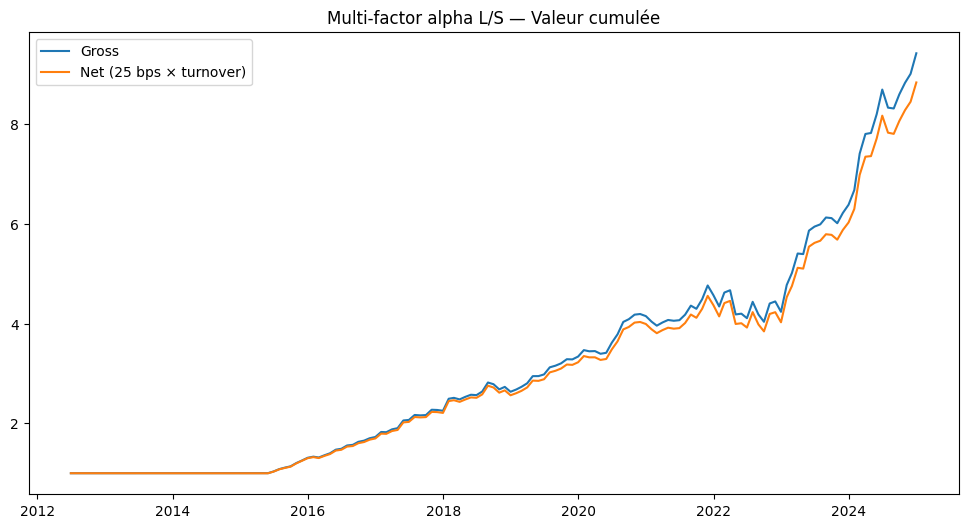

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(equity.index, equity, label="Gross")
plt.plot(equity_net.index, equity_net, label="Net (25 bps × turnover)")
plt.title("Multi-factor alpha L/S — Valeur cumulée")
plt.legend(); plt.show()


In [10]:
def sharpe(serie, freq=12):
    mu = serie.mean() * freq
    sd = serie.std(ddof=1) * np.sqrt(freq)
    return mu / sd if sd > 0 else np.nan

def max_dd(cum_curve):
    roll = cum_curve.cummax()
    dd = cum_curve/roll - 1
    return dd.min()

def perf_report(p, ec, to, freq=12):
    ann_ret = (1+p).prod()**(freq/len(p)) - 1
    ann_vol = p.std(ddof=1)*np.sqrt(freq)
    sr = ann_ret/ann_vol if ann_vol>0 else np.nan
    dd = max_dd(ec)
    skew = p.skew()
    kurt = p.kurtosis()
    avg_to = to.mean()*freq
    return pd.Series({
        "Annual Return": ann_ret,
        "Annual Volatility": ann_vol,
        "Sharpe": sr,
        "Max Drawdown": dd,
        "Skew": skew,
        "Kurtosis": kurt,
        "Avg Turnover (per year)": avg_to
    })

rep_gross = perf_report(pnl, equity, turnover)
rep_net   = perf_report(pnl_net, equity_net, turnover)
display(pd.DataFrame({"Gross": rep_gross, "Net": rep_net}))


,Gross,Net
Annual Return,0.195085,0.189013
Annual Volatility,0.112532,0.112155
Sharpe,1.733594,1.685283
Max Drawdown,-0.152894,-0.156355
Skew,0.408241,0.393952
Kurtosis,1.874179,1.871953
Avg Turnover (per year),2.082119,2.082119


In [11]:
# On ré-aligne pnl (mensuel) sur 'factors' (mensuel) :
pnl_aligned = pnl.reindex(factors.index).dropna()
X = sm.add_constant(factors.loc[pnl_aligned.index])
res = sm.OLS(pnl_aligned, X).fit()
print(res.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.295
Method:                 Least Squares   F-statistic:                     11.45
Date:                Wed, 27 Aug 2025   Prob (F-statistic):           1.90e-10
Time:                        23:34:18   Log-Likelihood:                 333.16
No. Observations:                 151   AIC:                            -652.3
Df Residuals:                     144   BIC:                            -631.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0114      0.002      4.833      0.0

### Interprétation des résultats

Notre stratégie multi-factorielle long/short basée sur le t-stat de l'alpha produit une performance robuste sur 2012–2024 :
- Rendement annualisé net ≈ **19%**, volatilité ≈ **11%**, Sharpe ≈ **1.7**.
- Drawdown maximum ≈ **-15%**, ce qui reste modeste.
- Skewness positive (≈0.4), ce qui traduit une distribution favorable : pertes limitées, gains extrêmes possibles.

L'analyse factorielle ex-post montre :
- Un **alpha annualisé ≈ 13%**, fortement significatif (t=4.8).
- Une exposition partielle au marché (bêta ≈ 0.32).
- Des biais factoriels : short SMB (préférence grandes capitalisations) et short CMA (préférence entreprises "agressives").
- Pas d'exposition significative à HML, RMW ou Momentum.

En résumé, la stratégie présente une forte génération d’alpha, un profil de risque maîtrisé, et une convexité implicite attractive. 
Néanmoins, les biais factoriels observés indiquent qu’elle n’est pas totalement neutre vis-à-vis de certains styles, ce qui devrait être surveillé en production.
